[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_2D.ipynb)

In [ ]:
!pip install JaxSSO
!pip install PyNiteFEA
!pip install nlopt

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PyNite as pyn #FEA solver
import JaxSSO as sso #Sensitivity analysis solver

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the FEA model
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [ ]:
#Definie the initial structure

#Meshes
x_span = 5 #span in x
y_span = 5 #span in y
nx, ny = (15, 15) #number of nodes in x/y
x = np.linspace(0, x_span, nx)
y = np.linspace(0, y_span, ny)
xv, yv = np.meshgrid(x, y) #meshed nodal coordinates, each in shape of (nx,ny)

#Intial nodal coordinates
n_node = nx * ny #number of nodes
x_nodes = [] #storing x nodes
y_nodes = [] #storing y nodes
z_nodes = [] #storing z nodes
design_nodes = [] #storing design nodes
non_design_nodes = [] #storing the fixed nodes, left boundary and right boundary, pinned
random_z = np.random.uniform(0,1) #random z coordinate @ design_nodes to start with
for i in range(n_node):
  x_temp = xv.ravel()[i] #flatten xv
  y_temp = yv.ravel()[i] #flatten yv
  if x_temp!=0 and x_temp!=x_span: #not on the left/right boundaries
    design_nodes.append(i)
    z_temp = random_z
  else: #on the left/right boundaries
    non_design_nodes.append(i)
    z_temp = 0
  x_nodes.append(x_temp)
  y_nodes.append(y_temp)
  z_nodes.append(z_temp)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = np.array(non_design_nodes,dtype=int)
x_nodes = np.array(x_nodes)
y_nodes = np.array(y_nodes)
z_nodes = np.array(z_nodes)

#Connectivity of elements
n_ele = (nx-1)*(ny) + (ny-1)*nx
cnct = np.zeros((n_ele,2),dtype=int) #connectivity info for the elements
x_ele = np.zeros((n_ele,2)) #x of the elements
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  #elements parallel to x
  if i < ((nx-1)*ny):
    ele_in_col = i%(nx-1) #which column is this element in
    ele_in_row = i//(nx-1) #which row is this element in
    cnct[i,0] = ele_in_col + ele_in_row*(nx)
    cnct[i,1] = (ele_in_col+1) + ele_in_row*(ny)
  
  #elements parallel to y
  else:
    ele_in_col = (i-(nx-1)*ny)%(nx)
    ele_in_row = (i-(nx-1)*ny)//(nx)
    cnct[i,0] = ele_in_col + ele_in_row*nx
    cnct[i,1] = ele_in_col + ele_in_row*nx + nx # one row above node i

  #Storing elements' coordinates
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -100000
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

Draw the initial structure

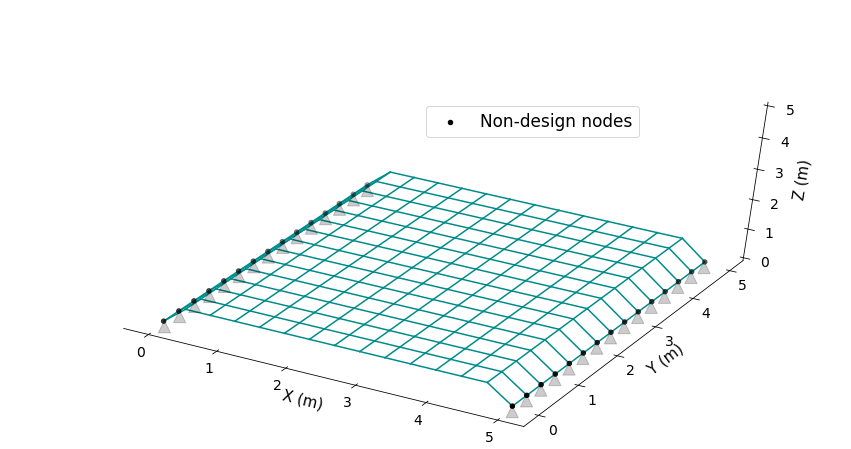

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,5)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(50, -60)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Inital FEA model

In [ ]:
#Build the model
model = pyn.FEModel3D() #model for FEA solving


#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):

  #Adding nodes
  model.add_node("{}".format(i),x_nodes[i],y_nodes[i],z_nodes[i])

  if i in design_nodes:
    model.add_node_load('{}'.format(i),'FZ',load,case='Case 1')
  else:
    model.def_support('{}'.format(i), True, True, True, False, False, False) #Pinned 

#Adding members
for i in range(n_ele):
  i_node = "{}".format(cnct[i,0]) #i-node of beam
  j_node = "{}".format(cnct[i,1]) #j-node of beam
  model.add_member("{}".format(i),i_node,j_node,E,G,Iy,Iz,J,A)



#Add load combo
model.add_load_combo('DEAD',{'Case 1':1})

Initial JaxSSO model

In [ ]:
#Build the model
sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):
  #Adding nodes
  sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])

#Adding elements
for i in range(n_ele):
  i_node = cnct[i,0]
  j_node = cnct[i,1]
  sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A)

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [ ]:
params_store = [] #store parameters
f_store = [] #store the functional value 

In [ ]:
def objective(x):
  params_store.append(x) #store params at each step

  #################
  #Function value#
  #################

  #Update nodes-z
  for i in range(design_nodes.shape[0]):
    model.Nodes[str(design_nodes[i])].Z = x[i] #update params in FEA model
    sens_model.nodes[design_nodes[i]].Z = x[i] #update params in SSO model
  
  #Update elements
  #In FEA model, the element is updated automatically,
  #here we only update SSO model
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) #update elements

  #FEA: solve [K]{u}={f}
  #Get {u}, displacement vector; C=0.5*{f}.T@{u}, compliance(strain energy)
  model.analyze(check_statics=False)
  u = model._D['DEAD'].reshape(-1) #displacement in 1-D vector
  C = 0.5*f@u #compliance of the system
  f_store.append(C) #store the compliance 

  ##################
  #  Gradient  #
  ##################
  #Get the sensitivity using SSO
  #Get the sensitivity using SSO
  sens = sens_model.Sens_C_Coord(u)
  z_dof_index = design_nodes*3+2 #index indicating the z-dof
  sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization

In [ ]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
optimizer = sso.Optimization.Optimization(n_x,method='GD')
optimizer.set_objective(objective) #objective function
optimizer.set_maxiter(500) #max iteration
optimizer.set_step_size(2e-4)
x_opt = optimizer.optimize(x_ini,log=True)

Step 0, objective = 10854.964813018134
Step 1, objective = 8251.140636767128
Step 2, objective = 6792.643591288879
Step 3, objective = 5936.910439453436
Step 4, objective = 5408.583577654368
Step 5, objective = 5063.958918504275
Step 6, objective = 4825.924654164379
Step 7, objective = 4651.902697203313
Step 8, objective = 4517.7220086287725
Step 9, objective = 4409.283926286667
Step 10, objective = 4318.14811408035
Step 11, objective = 4239.125494125601
Step 12, objective = 4168.938686694084
Step 13, objective = 4105.459013968646
Step 14, objective = 4047.2620996857722
Step 15, objective = 3993.365023129755
Step 16, objective = 3943.0677284288604
Step 17, objective = 3895.854709324456
Step 18, objective = 3851.3351807100444
Step 19, objective = 3809.203633506616
Step 20, objective = 3769.214657428356
Step 21, objective = 3731.1663494903405
Step 22, objective = 3694.889660194977
Step 23, objective = 3660.2398605500025
Step 24, objective = 3627.091387048098
Step 25, objective = 3595.334

# Visualization

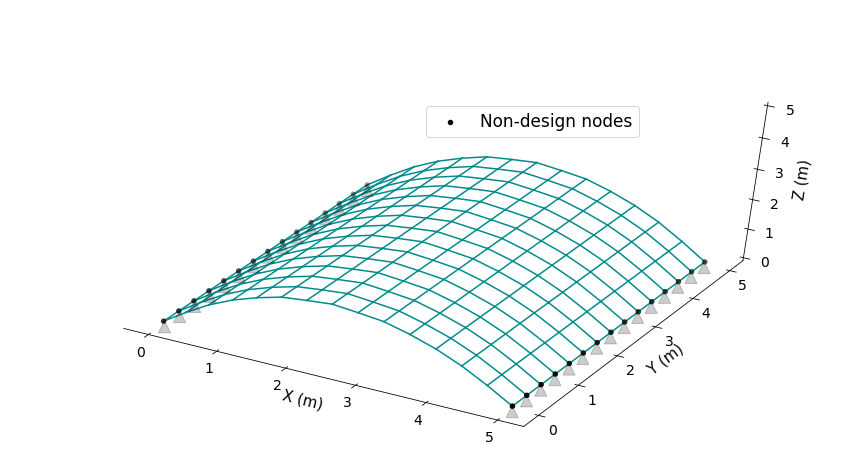

In [ ]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,5)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(50, -60)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()